In [1]:
%matplotlib inline

In [2]:
# This notebook creates a raster plot with annual streamflow anomalies (Figure 2 in manuscript)

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os
plt.rcParams['font.family'] = 'Arial' 

In [4]:
# Define path to save plots
save_path = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\paper\Figures_Final")

# Read the catchment characteristics - Extract area_calc and human influence
catchments_chara = pd.read_csv(Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\Catchment_attributes.csv'),sep=';')
catchments_chara = catchments_chara.set_index('id')

# Define a function to adjust the start and end times to water-year start and end dates for each streamflow series
def adjust_columns_to_full_water_years(df):
    adjusted_dfs = []

    # Iterate through each column
    for col in df.columns:
        # Get the first and last dates for the specific column
        first_date = df[col].dropna().index.min()
        last_date = df[col].dropna().index.max()

        # Adjust the start date to the nearest October 1 for the first full water year
        if first_date.month < 10:
            first_full_water_year_start = pd.Timestamp(year=first_date.year, month=10, day=1)
        else:
            first_full_water_year_start = pd.Timestamp(year=first_date.year + 1, month=10, day=1)

        # Adjust the end date to the nearest September 30 for the last full water year
        if last_date.month >= 9:
            last_full_water_year_end = pd.Timestamp(year=last_date.year, month=9, day=30)
        else:
            last_full_water_year_end = pd.Timestamp(year=last_date.year - 1, month=9, day=30)

        # Filter the dataframe to include only full water years for this column
        adjusted_dfs.append(df[col].loc[first_full_water_year_start:last_full_water_year_end])

    # Combine the adjusted columns back into a single dataframe
    return pd.concat(adjusted_dfs, axis=1)

# Read multiple streamflow series into a DataFrame (one column per gauge)
path_to_streamflow = Path(r"monthly_averages_longterm_missing_thresh_90_percent_nov14.csv")
df_streamflow_all = pd.read_csv(path_to_streamflow, index_col='Unnamed: 0', parse_dates=True)  # Replace with your actual file and structure
df_streamflow_all_adj = adjust_columns_to_full_water_years(df_streamflow_all)
df_streamflow_all_adj_ann = df_streamflow_all_adj.resample('A-SEP').mean()

# Drop gauge with ID 9 (Syðri-Bægisá River, due to inhomogeneity in the series)
df_streamflow_all_adj_ann = df_streamflow_all_adj_ann.drop(columns='9') 

# Calculate long-term mean for each series
long_term_mean = df_streamflow_all_adj_ann.mean()

window_size = 5  # Define the rolling window size

df_streamflow_all_adj_ann_rolling = df_streamflow_all_adj_ann.rolling(window=window_size, center=True).mean()

river_title_dict = {
    58: 'Korpa (58)',
    21: 'Fossá (21)',
    67: 'Norðurá (67)',
    91: 'Vatnsdalsá (91)',
    83: 'Svartá, Skagafjörður (83)',
    8: 'Brúará (8)',
    70: 'Sandá, Þistilfjörður (70)',
    12: 'Dynjandisá (12)',
    39: 'Hólmsá, Reykjavík (39)',
    84: 'Svartá, Bárðardalur (84)',
    34: 'Hvalá (34)',
    64: 'Laxá, Aðaldalur (64)',
    82: 'Suðurá, Reykjavík (82)',
    79: 'Sog (79)',
    14: 'Eystri-Rangá (14)',
    31: 'Hjaltadalsá (31)',
    3: 'Austari-Jökulsá (3)',
    86: 'Tungnaá (86)',
    7: 'Blanda (7)',
    93: 'Vestari-Jökulsá (93)',
    98: 'Ölfusá (98)',
    102: 'Þjórsá (102)',
    37: 'Hvítá, Borgarfjörður (37)',
    11: 'Djúpá (11)',
    46: 'Jökulsá á Fjöllum (46)',
    43: 'Jökulsá á Dal (43)'
}

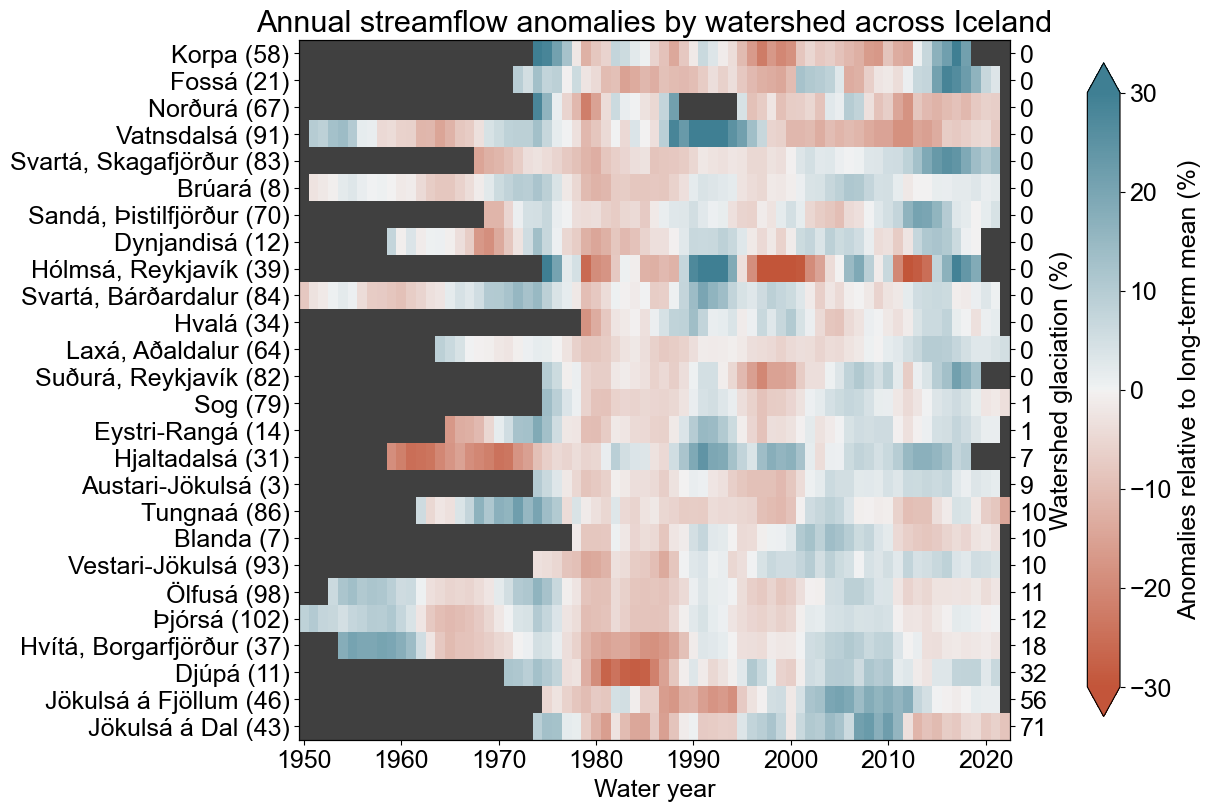

In [8]:
# Define sorting by glaciation percentage
sortby = 'glac_fra'
fontsize = 18
title_fontsize = 22
xtick_labelsize = 18 # Size for the x-axis tick labels

# Calculate deviations from the long-term mean (in percentages)
deviations_percent = ((df_streamflow_all_adj_ann_rolling - long_term_mean) / long_term_mean) * 100
deviations_percent = deviations_percent['1949-10-01':'2022-09-30']
# deviations_percent = deviations_percent.dropna(axis=1, how='all')

# Create diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True).reversed()
cmap.set_bad(color='#404040')  # Set bad color for NaN values

# Sort the streamflow gauges by glaciation percentage
listi = catchments_chara[sortby].loc[[int(i) for i in deviations_percent.columns]].sort_values().index.tolist()
listi_str = [str(i) for i in listi]
deviations_percent = deviations_percent[listi_str]

# Create figure
#fig, ax = plt.subplots(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

# Plot heatmap
im = ax.imshow(deviations_percent.T, cmap=cmap, aspect='auto', vmin=-30, vmax=30, interpolation='none')

# Modify x-tick positions and labels to show only specific years divisible by 5
selected_years = deviations_percent.index.year
selected_years = selected_years[selected_years % 10 == 0]  # Show only years divisible by 5

# Get positions corresponding to `selected_years`
xtick_positions = np.where(np.isin(deviations_percent.index.year, selected_years))[0]
xtick_labels = [str(year) for year in selected_years]

# Set x-ticks and labels only for selected years
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=xtick_labelsize)

# Set y-ticks for Streamflow Gauge ID
ytick_positions = np.arange(len(deviations_percent.columns))
listi_int = [int(i) for i in listi_str]
ytick_labels = [river_title_dict[i] for i in listi_int]

ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels, fontsize=fontsize)
# ax.set_ylabel('Streamflow Gauge ID', fontsize=fontsize)

# Create a secondary y-axis for glaciation percentages
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

# Get glaciation values corresponding to the streamflow gauge IDs
glaciation_values = 100 * catchments_chara.loc[[int(i) for i in deviations_percent.columns]]['glac_fra'].sort_values()
glaciation_values = glaciation_values.astype(int)

# Set y-ticks for glaciation values
ax2.set_yticks(ytick_positions)
ax2.set_yticklabels(glaciation_values, fontsize=fontsize)

# Adjust the labelpad to bring the label closer to the heatmap
ax2.set_ylabel('Watershed glaciation (%)', fontsize=fontsize, labelpad=2)  # Decrease labelpad to move the label closer

# Adjust colorbar positioning and extend both sides
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02, extend='both')  # Set extend='both'
cbar.set_label('Anomalies relative to long-term mean (%)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Set the title and labels
#plt.title('Measured Streamflow: Water-Year Deviations from Long-Term Mean', fontsize=title_fontsize)

plt.title('Annual streamflow anomalies by watershed across Iceland', fontsize=title_fontsize)
ax.set_xlabel('Water year', fontsize=fontsize)

# Save the figure as PDF
pdf_save_path = os.path.join(save_path, 'Figure2_streamflow_anomalies.pdf')
plt.savefig(pdf_save_path, dpi=300, format='pdf', bbox_inches='tight')

# Save the figure as PNG
png_save_path = os.path.join(save_path, 'Figure2_streamflow_anomalies.png')
plt.savefig(png_save_path, dpi=300, format='png', bbox_inches='tight')

# Display the plot
plt.show()